# Giysi Görüntülerinin Sınıflandırılması



Bu başlık altında, spor ayakkabı ve gömlek gibi giyim görüntülerini sınıflandırmak için bir sinir ağı oluşturup sonrasında bu ağı eğiteceğiz.

Her kodu anlamazsanız sorun etmeyin. Colab dosyaları boyunca açıklamalar ile birlikte TensorFlow programına giriş niteliğinde bir döküman oluşturacağız.

Bu kılavuz, TensorFlow ile modeller oluşturmak ve eğitmek için geliştirilen üst düzey bir API olan  [tf.keras](https://www.tensorflow.org/guide/keras) kullanılmaktadır.

## Gerekli Kurulumların ve İçe Aktarmaları Yapalım

Veri kümelelerini indirmeyi, erişmeyi basitleştiren ve çalışmak için birçok örnek veri kümesi sağlayan bir API olan [TensorFlow Datasets](https://www.tensorflow.org/datasets/) kullanacağız. Bununla birlikte birkaç yardımcı Python kütüphanesi kullanmamız gerekiyor.

In [1]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.9 MB 5.1 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
import tensorflow as tf

In [3]:
# TensorFlow Datasets'in içeri aktarılması
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Yardımcı olacak diğer Python kütüphaneleri
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Ve önceki colab dosyalarında olduğu gibi hataları görmek için gereken kod bloğu
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Fashion MNIST Veri Setinin İçeri Aktarılması

Bu başlık altında, 10 kategoride 70000 gri tonlamalı görüntü içeren [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) veri kümesini kullanıyoruz. Görüntüleri aşağıda görüldüğü gibi düşük çözünürlükte (28 x 28 piksel) olan ve her bir ayrı ayrı giyim eşyaları olan görsellerdir.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

**Fashion MNIST**, genellikle bilgisayarlı görü için makine öğrenimi programlarının "Merhaba Dünya!"sı (Hello World!) olarak kullanılan klasik [MNIST](http://yann.lecun.com/exdb/mnist/) veri setinin yerini alacak şekilde tasarlanmıştır. MNIST veri seti, burada kullanacağımız giyim eşyalarıyla aynı formatta el yazısı rakamlarından oluşan (0, 1, 2, vb.) görüntüleri de içerir.

Bu kılavuz, Fashion MNIST'i çeşitlilik için kullanır çünkü bu normal MNIST veri setinden biraz daha zorlayıcı problemler içerir. Her iki veri kümesi de küçüktür ve bir algoritmanın beklendiği gibi çalışıp çalışmadığını kontrol etmek (doğrulamak) için kullanılır. Kodu test etmek ve hata ayıklamak için iyi bir seçimdir.

Sinir ağımızı eğitmek için 60000 görüntü ve ağın görüntüleri sınıflandırmayı ne kadar doğru yaptığını değerlendirmek için 10000 görüntü kullanacağız. Fashion MNIST veri setine [Datasets](https://www.tensorflow.org/datasets) API sayesinde doğrudan TensorFlow üzerinden erişebiliriz.


In [6]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Veri kümesini yüklediğimizde eğitim ve test veri kümesinin yanı sıra meta verilerini de geri döndürür.

* Modeli `train_dataset` kullanarak eğiteceğiz.
* Modeli `test_dataset` kullanarak test edeceğiz.

Görüntüler, piksel değerleri `0-255` aralığında olan 28 x 28 bir dizidir. Etiketler ise `0-9` aralığında bir tam sayı dizisidir. Bu sayılar, görüntünün temsil ettiği giysi sınıfına karşılır gelir:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Her görüntü tek bir etiketle eşleşir. Sınıf adları veri kümesine dahil edilmediği inin, daha sonra görüntüleri çizerken kullanmak üzeri onları saklayalım : 


In [7]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Verileri Keşfedelim

Modeli eğitmeden önce veri kümesinin biçimini inceleyelim. Aşağıdakiler, eğitim setinde 60000 ve test setinde ise 10000 görüntü olduğunu göstermektedir.

In [9]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Eğitim veri setimizdeki örnek sayımız : {}".format(num_train_examples))
print("Test veri setimizdeki örnek sayımız   : {}".format(num_test_examples))

Eğitim veri setimizdeki örnek sayımız : 60000
Test veri setimizdeki örnek sayımız   : 10000


## Verilerin Ön İşlenmesi

Görüntü verilerindeki her pikselin değer `0-255` aralığında bir tam sayıdır. Modelin düzgün çalışması için bu değerlerin `0-1` aralığına normalleştirilmesi gerekir. Yani burada bir normelleştirme işlevi (fonksiyonu) oluşturuyoruz ve ardından bunu hem eğitim hem de test veri setimizdeki her görüntüye uyguluyoruz.


In [10]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# map işlevi, normelleştirmeyi eğitim ve test veri setimizdeki her öğeye uygular.
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Veri setini ilk kullandığımızda, görüntüler diskten yüklenecektir.
# Ön belleğe alma, onları bellekte tutacak ve eğitimi daha hızlı hale getirecektir.
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### İşlenen Verilere Göz Atalım

Nasıl göründüklerini görmek için `matplotlib` kütüphanesini kullanarak resimlerini çizelim.

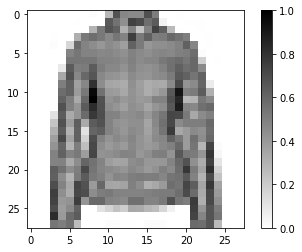

In [11]:
# Tek bir görüntü alır ve yeniden şekillendirir. Renk boyutunu kaldırır.
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Resmi çizdirelim.
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Şimdi de eğitim setindeki ilk 25 resmi görüntüleyelim ve her resmin altında sınıf adını görüntüleyelim. Verilerin doğru biçimde olduğunu doğruladıktan sonra ağı oluşturmaya ve ağımızı eğitmeye geçebiliriz.

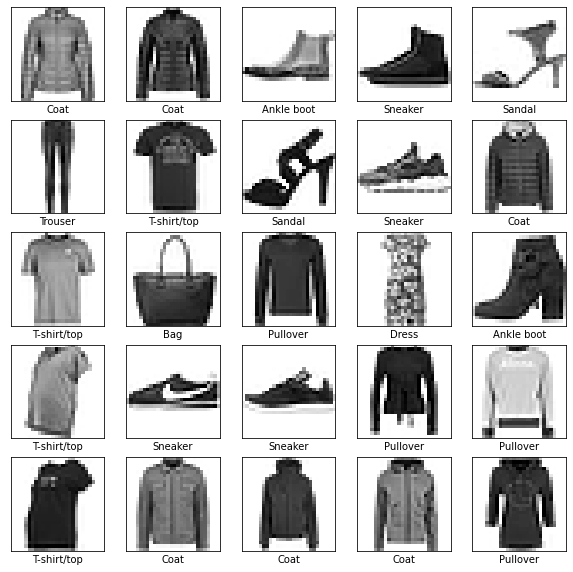

In [12]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(test_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

## Modelin Oluşturulması

Sinir ağının oluşturulması, modelin katmanlarının ayarlanması ve ardından modelin derlenmesi aşamalarının bütünüdür.

### Katmanların Ayarlanması

Bir sinir ağının temel yapı taşı katmanlardır (*layer*). Bir katman, kendisini besleyen (girdi olarak gelen) verilerden bir temsil çıkarır.

Derin öğrenmenin çoğı, basit katmanların birbirine zincirlenmesinden oluşmaktadır. `tf.keras.layers.Dense` gibi çoğu katman, eğitim sırasında ayarlanan yani öğrenilen (*learned*) dahili parametrelere sahiptir.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Bu ağın üç katmanı vardır:

* **Girdi (input) :** `tf.keras.layers.Flatten` — Bu katman görüntüleri 28 x 28 piksellik bir 2 boyutlu diziden 784 (28*28) piksellik bir boyutlu bir diziye dönüştürür. Bu katmanı, görüntüdeki piksel sıralarını kaldırmak ve bunları hizalamak olarak düşünebiliriz. Bu katman, yalnızca verileri yeniden biçimlendirmek için kullanıldığı için öğrenilecek parametreye sahip değildir.

* **Gizlenmiş (hidden) :** `tf.keras.layers.Dense` — 128 nörondan oluşan yoğun bağlantılı bir katmandır. Her nöron (veya düğüm), önceki katmandaki 784 düğümün hepsinden girdi alır ve bu girdiyi eğitim sırasında öğrenilecek gizli parametrelere göre ağırlıklandırır. Bu işlemden sonra sonraki katmana tek bir değer verir.

* **Çıktı (output) :** `tf.keras.layers.Dense` — 128 nörondan ve 10 düğümlü bir softmax katmanıdır. Her düğüm bir giysi sınıfını temsil etmektedir. Önceki katmanda olduğu gibi, son katman önceki katmandaki 128 düğümden girdi alır ve görüntünün o sınıfa ait olma olasılığını temsil eden `0-1` arası bir değer verir. 10 düğümdeki değerlerin toplamı 1 olmalıdır.




> Not: `softmax` aktivasyonu ve `SparseCategoricalCrossentropy()` kullanımında sorunlar vardı ve bunlar `tf.keras` modeli tarafından düzeltildi. Genel olarak daha güvenli bir yaklaşım olarak `SparseCategoricalCrossentropy(from_logits=True)` ile aktivasyon fonskiyonu olmadan doğrusal bir çıktı kullanılır.

### Modelin Derlenmesi

Model eğitime hazır olmadan önce birkaç ayara daha ihtiyacı var. Bunlar modelin derleme adımı sırasında eklenir:

* Kayıf Fonksiyonu (*Loss Function*) — Modelin çıktıların istenen çıktıdan ne kadar uzakda olduğunu ölçmek için bir algoritmadır. Eğitimin amacı, bu kaybı ölçmektir.

* Optimize Edici (*Optimizer*) — Kaybı en aza indirmek için modelin iç parametrelerini ayarlamada kullanılan bir algoritmadır.

* Metrikler (*Metrics*) — Eğitim ve test adımlarını izlemek için kullanılır. Aşağıdaki kod bloğunda metrik olarak `accuracy` yani doğruluk metriği kullanılmıştır.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Modelin Eğitilmesi

İlk olarak, eğitimm ve veri setimiz için yineleme davranışını tanımlarız:

1. `dataset.repeat()` öğesini belirterek sonsuza kadar tekrarlarız. (Aşağıdaki `epochs` parametresi, ne kadar süreyle eğitim gerçekleştireceğimizi sınırlar.)

2. `dataset.shuffle(60000)` sırayı rastgele olarak ayarlar, böylece modelimiz örneklerin sırasından dolayı hiçbir şey öğrenmemiş olur.

3. `dataset.batch(32)` ise `model.fit` yöntemine, model değişkenlerini güncellerken 32 görüntü ve etiketten oluşan yığınları kullanmasını söyler.

`model.fit` yöntemi çağrılarak eğitim gerçekleştirilir:
1. `train_dataset` kullanarak eğitim verileriyle modelimizi besleriz.
2. Modelimiz görüntüleri ve etiketleri ilişkilendirmeyi öğrenir.
3. `epochs = 5` parametresi, eğitim veri kümesi ile eğitimin 5 tam yinelenmesi ile sınırlar, yani model tplam 5* 60000 = 300000 girdi alır.




In [15]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [16]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 9s 2ms/step - loss: 0.4929 - accuracy: 0.8257
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3685 - accuracy: 0.8681
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3375 - accuracy: 0.8766
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3122 - accuracy: 0.8845
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2920 - accuracy: 0.8931


Model ilerlerken, kayıp (loss) ve doğruluk (accuracy) metriklerigörüntüülenir. Bu model, eğitim verilerinde yaklaşık 0.89 (%89) doğruluğa ulaşır.

## Doğruluğun (accuracy) Değerlendirilmesi

Sırada modelin test veri kümesinde nasıl performans gösterdiğini görelim. Doğrulu değerlendirmek için test veri setindeki tüm örnekleri kullanalım.

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Test veri setinin doğruluk (accuracy) değeri:', test_accuracy)

313/313 [==============================] - 2s 4ms/step - loss: 0.3561 - accuracy: 0.8722
Test veri setinin doğruluk (accuracy) değeri: 0.8722000122070312


Sonuç olarak, test veri setindeki doğruluk eğitim veri setindeki doğruluktan daha küçüktür. Model, `train_dataset` üzerinden eğitildiği için bu tamamiyle normaldir. Model, eğitim sırasında hiç görmediği (yani `test_dataset`) görüntülerle karşılaştığında, performansının düşmesini bekleyebiliriz.

## Tahminlerde Bulunma

Eğitilen modeli bazı görüntüler hakkında tahmin yapmak için kullanabiliriz.

In [18]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [19]:
predictions.shape


(32, 10)

Burada model, test setindeki her görüntğ için etiket tahmin etmiştir. İlk tahminine bir göz atalım : 

In [20]:
predictions[0]

array([1.4138373e-05, 3.2118066e-07, 2.0027706e-02, 2.9864859e-06,
       9.5776451e-01, 1.5086441e-08, 2.2183143e-02, 3.8267519e-08,
       7.1750851e-06, 5.0645149e-10], dtype=float32)

Tahmin, 10 sayıdan oluşan bir dizidir. Bu değerler, görüntünün 10 farklı giysi sınıfından her birine eşleşme durumunun güvenilirliğini (confidence) tanımlar. Hangi etiketin en yüksek güven değerine sahip olduğunu görebiliriz:

In [21]:
np.argmax(predictions[0])

4

Çıktıdan anlaşılacağı gibi, bu görüntünün kaban veya `class_names[4]` olduğundan çok emindir. Bunun doğru olup olmadığını görmek için test etiketini kontrol edebiliriz :

In [22]:
test_labels[0]

4

Verilen çıktı modelimizin tahminini doğrular nitelikte. 10 sınıf tahminlerinin tamamına bakmak için bunun grafiğini çizebiliriz:

In [23]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Hadi sıfırıncı (0.) görüntüye ve tahmin dizisine bakalım :

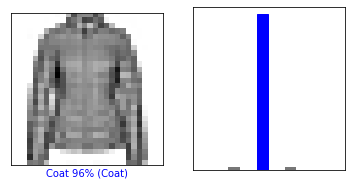

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

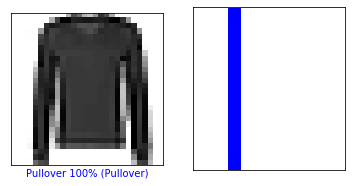

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Şimdi de tahminlerle birlikte birkaç resim çizelim. Doğru tahmin edilen etiketler mavi ve yanlış tahmin edilenler kırmızı renkle görünecektir. Sayı ise tahmin edilen etiket için yüzdeyi verir. Güven çok yüksek olsa bile yanlış çıkabileceği gerçeğini unutmayalım.

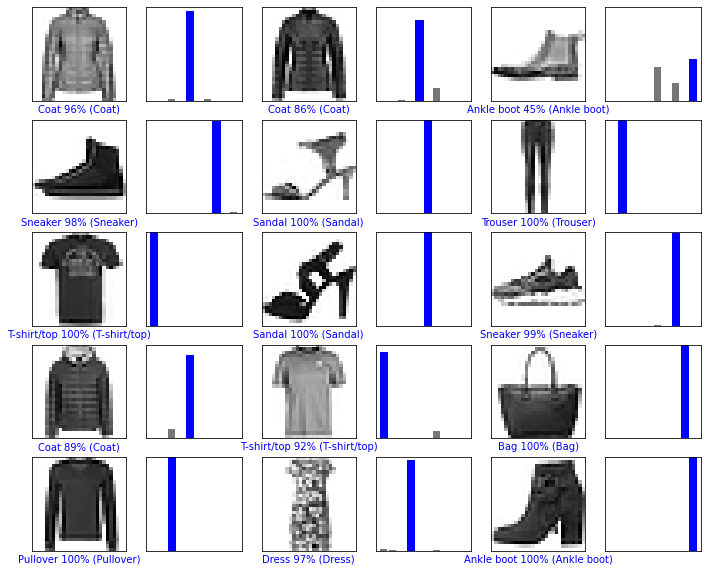

In [26]:
# İlk test görüntülerini, ardından tahmin edilen ve gerçek etiketleri gösterelim.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Şimdi de tek bir görüntü hakkında tahminde bulunmak için eğitmiş olduğumuz modeli kullanalım:

In [27]:
# Test veri kümesinden bir görüntü alalım
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` modelleri, bir seferde bir grup veya örnek koleksiyonu üzerinde tahminler yapmak için optimize edilmiştir. Yani tek bir resim kullanıyor olsak bile onu bir listeye eklememiz gerekir.

In [28]:
# Resmi tek üyenin olduğu bir listeye ekleyelim
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Ve şimdi resmi tahmin etme zamanı :

In [29]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.4138346e-05 3.2118035e-07 2.0027725e-02 2.9864943e-06 9.5776451e-01
  1.5086410e-08 2.2183180e-02 3.8267519e-08 7.1750992e-06 5.0645149e-10]]


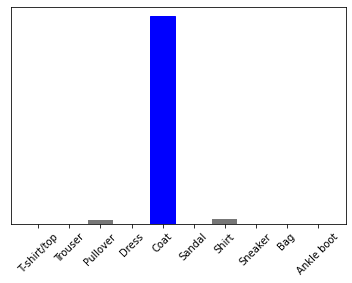

In [30]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model_predict`, veri yığınındaki ger görüntü için bir tane olmak üzere bir liste döndürür. Gruptaki sadece resmimizi ilgilendiren tahminleri alalım :

In [31]:
np.argmax(predictions_single[0])

4

Daha önce de olduğu gibi modelimiz 4 numaralı sınıfı yani kaban etiketini tahmin ediyor.